# Image recognition
In this project, I used mixture gaussian model to distinguish apple in an image which is based on EM algorithm. Note that matrix operations is crucial for time-efficiency when fitting the model rather than using for loops.

In [1]:
from imread import imread
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
image_list =["apples/apples/Apples_by_kightp_Pat_Knight_flickr",
             "apples/apples/ApplesAndPears_by_srqpix_ClydeRobinson",
             "apples/apples/bobbing-for-apples"]
             
def collect_apple_point(image_list):
    apple_data = []
    non_apple_data = []
    for image in image_list:
        mask = imread(image + ".png")
        origin = imread(image + ".jpg") / float(255)
        d1, d2, d3 = origin.shape
        for i in range(d1):
            for j in range(d2):
                if mask[i,j,0] != 0:
                    apple_data.append(origin[i,j,:])
                else:
                    non_apple_data.append(origin[i,j,:])
    return np.array(apple_data).transpose(), np.array(non_apple_data).transpose()

apple_data, non_apple_data = collect_apple_point(image_list)


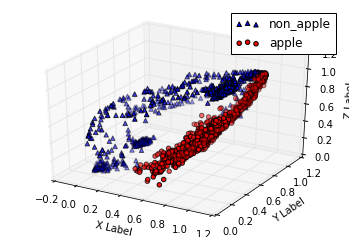

In [3]:
k = 1000
x_non = non_apple_data[0][:k]
y_non = non_apple_data[1][:k]
z_non = non_apple_data[2][:k]

x = apple_data[0][:k]
y = apple_data[1][:k]
z = apple_data[2][:k]

fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')

ax.scatter(x_non, y_non, z_non, c='b', marker='^', label="non_apple")
ax.scatter(x,y,z, c='r',marker='o', label="apple")

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.legend()
plt.show()

In [4]:
from scipy.stats import multivariate_normal
def getProb(point,mean,cov):
    return multivariate_normal(mean=mean, cov=cov).pdf(point)

In [5]:
def getBoardCastProb(point,mixGauss):
    k = mixGauss['k']
    boardcastProb = np.array([getProb(point, mixGauss['mean'][:,i], mixGauss['cov'][:,:,i]) for i in range(k)])
    return boardcastProb.reshape(1,k)

def getMixGaussLogLike(data, mixGaussEst):                                                             
    data = np.atleast_2d(data)  
    
    # find total number of data items                                                                  
    nDims, nData = data.shape                                                                          
    k = mixGaussEst['k']                                                                                                                                                                             
    tran_data = data.transpose()
    prob_stack = np.ones(shape=(nData,k))
    
    for cGauss in range(k):
        temp_prob = getProb(tran_data,mixGaussEst['mean'][:,cGauss],mixGaussEst['cov'][:,:,cGauss]).reshape(1,nData)
        prob_stack[:,cGauss] = temp_prob * mixGaussEst['weight'][cGauss]
        
    logLike = np.sum(np.log(np.sum(prob_stack,axis = 1)))
    return logLike                                                                                                                                                                                                                                                                

In [6]:
# mixture gaussian model
def fitMixGauss(data, k):
    nDims, nData = data.shape
    print(nDims,nData)

    #     MAIN E-M ROUTINE
    #     there are nData data points, and there is a hidden variable associated
    #     with each.  If the hidden variable is 0 this indicates that the data was
    #     generated by the first Gaussian.  If the hidden variable is 1 then this
    #     indicates that the hidden variable was generated by the second Gaussian
    #     etc.

    responsibilities = (1 / k) * np.ones(shape=(k, nData))    

    #     in the E-M algorithm, we calculate a complete posterior distribution over
    #     the (nData) hidden variables in the E-Step.  In the M-Step, we
    #     update the parameters of the Gaussians (mean, cov, w).

    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    
    mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    for i in range(k):
        r = int(np.floor(np.random.uniform()*nData)) 
        mixGaussEst['mean'][:,i] = data[:,r]
    
    mixGaussEst['cov'] = 3 * np.ones(shape=(nDims, nDims, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 0.5 + 1.5 * np.random.uniform() * np.eye(nDims)
    
    logLike = getMixGaussLogLike(data, mixGaussEst)
    print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLike))

    nIter = 30
    for cIter in range(nIter):
        # ===================== =====================
        # Expectation step
        # ===================== =====================
        tran_data = data.transpose()
        prob_stack = np.ones(shape=(nData,k))
        prob_margin = np.zeros(shape=(nData,1))
        for cGauss in range(k):
            temp_prob = getProb(tran_data,mixGaussEst['mean'][:,cGauss],mixGaussEst['cov'][:,:,cGauss]).reshape(1,nData)
            prob_stack[:,cGauss] = temp_prob
            prob_margin += temp_prob.transpose() * mixGaussEst['weight'][cGauss]
        
        responsibilities = (prob_stack / prob_margin).transpose()
            
        # ===================== =====================
        # Maximization Step
        # ===================== =====================
        # for each constituent Gaussian
        totalRespon = np.sum(responsibilities)
        for cGauss in range(k):
            sumRk = sum(responsibilities[cGauss])
            mixGaussEst['weight'][cGauss] = sumRk / float(totalRespon)                                                                              
            weightedData = responsibilities[cGauss] * data
            weightedX = np.sum(weightedData,axis=1)
            mixGaussEst['mean'][:,cGauss] = weightedX / float(sumRk)                                           
            newMean = (weightedX / float(sumRk)).reshape(3,1)
            weightedCovMatrix = (responsibilities[cGauss] * (data - newMean)) @ (data - newMean).transpose()
            mixGaussEst['cov'][:,:,cGauss] = weightedCovMatrix / float(sumRk)
        
        # calculate the log likelihood
        logLike = getMixGaussLogLike(data, mixGaussEst)
        #print('Log Likelihood After Iter {} : {:4.3f}\n'.format(cIter, logLike))

    return mixGaussEst

In [7]:
def numberData(tolData,n):
    data = tolData.transpose()[:n]
    return data.transpose()

In [8]:
apple = apple_data
non_apple = non_apple_data

In [9]:
print(apple.shape)
print(non_apple.shape)

(3, 429646)
(3, 370654)


In [10]:
apple_model = fitMixGauss(apple,3)

3 429646
Log Likelihood Iter 0 : -1549898.769



In [11]:
non_apple_model = fitMixGauss(non_apple,3)

3 370654
Log Likelihood Iter 0 : -1362037.770



In [12]:
apple_model

{'cov': array([[[ 0.02771554,  0.03092384,  0.02297738],
         [ 0.02335264,  0.00421424,  0.01231961],
         [ 0.00453162,  0.00757789,  0.0240086 ]],
 
        [[ 0.02335264,  0.00421424,  0.01231961],
         [ 0.02104008,  0.00922642,  0.04908045],
         [ 0.00519734,  0.00486933,  0.03594457]],
 
        [[ 0.00453162,  0.00757789,  0.0240086 ],
         [ 0.00519734,  0.00486933,  0.03594457],
         [ 0.00744606,  0.00511812,  0.04931965]]]),
 'd': 3,
 'k': 3,
 'mean': array([[ 0.54739073,  0.42529282,  0.69760075],
        [ 0.62130768,  0.11370443,  0.62089812],
        [ 0.08175807,  0.07826143,  0.4334173 ]]),
 'weight': array([ 0.32044106,  0.3314445 ,  0.34811444])}

In [13]:
non_apple_model

{'cov': array([[[ 0.08884345,  0.02397519,  0.02596395],
         [ 0.09051979,  0.00698473,  0.02402954],
         [ 0.09230098,  0.00100974,  0.01557683]],
 
        [[ 0.09051979,  0.00698473,  0.02402954],
         [ 0.09436765,  0.00804932,  0.0324665 ],
         [ 0.09765928,  0.00076944,  0.0171075 ]],
 
        [[ 0.09230098,  0.00100974,  0.01557683],
         [ 0.09765928,  0.00076944,  0.0171075 ],
         [ 0.10502906,  0.00052561,  0.03409586]]]),
 'd': 3,
 'k': 3,
 'mean': array([[ 0.52444626,  0.17468843,  0.59426154],
        [ 0.51277707,  0.08152312,  0.48693369],
        [ 0.49732061,  0.0205371 ,  0.22453975]]),
 'weight': array([ 0.34876365,  0.30237382,  0.34886253])}

In [14]:
def getMixGassProb(image,mixGauss):
    k = mixGauss['k']
    x, y, z = image.shape
    new_image = np.zeros(shape = (x,y))
    for i in range(k):
        new_image += (getProb(image, mixGauss['mean'][:,i], mixGauss['cov'][:,:,i]) * mixGauss['weight'][i])
    return new_image

In [15]:
test_image = imread('apples/apples/Apples_by_kightp_Pat_Knight_flickr.jpg')/ float(255)
gt = imread('apples/apples/Apples_by_kightp_Pat_Knight_flickr.png')
print(gt.shape)

(397, 500, 4)


In [16]:
def geneAppleMask(image,apple_model,non_apple_model):
    prob_apple = getMixGassProb(image,apple_model)
    prob_non_apple = getMixGassProb(image,non_apple_model)
    posteri_apple = prob_apple / (prob_apple + prob_non_apple)
    return posteri_apple

In [17]:
distin = geneAppleMask(test_image,apple_model,non_apple_model)

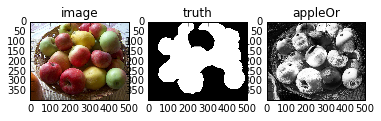

In [18]:
f, (ax1,ax2,ax3) = plt.subplots(1,3)
ax1.imshow(test_image)
ax1.set_title("image")
ax2.imshow(gt)
ax2.set_title("truth")
ax3.imshow(distin,cmap = 'gray')
ax3.set_title("appleOr")
plt.show()

In [19]:
def distinApple(image,truth,apple_model,non_apple_model):
    # 1 for apple, 0 for else
    x,y,z = image.shape
    distin = np.ones([x,y])
    y_true = []
    y_pred = []
    y_prob = []
    
    gene_mask = geneAppleMask(image,apple_model,non_apple_model)
    x, y = gene_mask.shape
    
    for i in range(x):
        for j in range(y):
            posteri_apple = gene_mask[i,j]
            y_prob.append(posteri_apple)
            if posteri_apple > 0.5:
                y_pred.append(1)
            else:
                y_pred.append(0)
            if truth[i,j,0] == 255:
                y_true.append(1)
            else:
                y_true.append(0)
            
    return gene_mask, y_pred, y_true, y_prob

In [29]:
from sklearn.metrics import confusion_matrix
test_image = imread('apples/testApples/Bbr98ad4z0A-ctgXo3gdwu8-original.jpg') / float(255)
gt = imread('apples/testApples/Bbr98ad4z0A-ctgXo3gdwu8-original.png')
distin, y_pred, y_true, y_prob = distinApple(test_image, gt, apple_model, non_apple_model)
confusions = confusion_matrix(y_true, y_pred)

In [30]:
print(confusions)
tn, fp, fn, tp = confusions.ravel()

[[2564226   52036]
 [  32097  351641]]


In [31]:
print("tn",tn,'\n'"fp",fp,'\n'"fn",fn,'\n'"tp",tp)

tn 2564226 
fp 52036 
fn 32097 
tp 351641


In [32]:
# Leart from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
from sklearn.metrics import roc_curve, auc, roc_auc_score
def plotROC(y_true, y_prob):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(1):
        fpr[i], tpr[i], _ = roc_curve(y_true, y_prob)
        roc_auc[i] = auc(fpr[i], tpr[i])

    print("ROC area under curve score:",roc_auc_score(y_true, y_prob))
    plt.figure()
    plt.plot(fpr[0], tpr[0])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.show()

ROC area under curve score: 0.99151240977


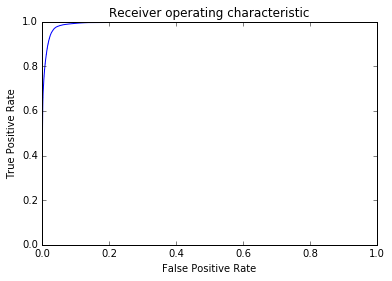

In [33]:
plotROC(y_true,y_prob)

In [34]:
def plot_mask(file):
    image = imread(file)/ float(255)
    gene_image = geneAppleMask(image,apple_model,non_apple_model)
    f, (ax1,ax2) = plt.subplots(1,2)
    ax1.imshow(image)
    ax1.set_title("image")
    ax2.imshow(gene_image,cmap='gray')
    ax2.set_title("mask")
    plt.show()

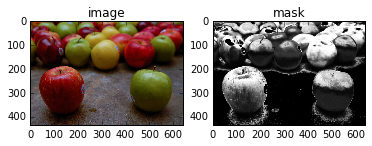

In [35]:
file = "apples/testApples/Apples_by_MSR_MikeRyan_flickr.jpg"
plot_mask(file)

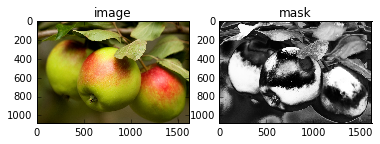

In [36]:
file = 'apples/testApples/audioworm-QKUJj2wmxuI-original.jpg'
plot_mask(file)

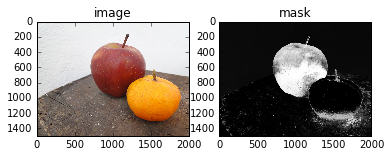

In [37]:
file = 'apples/testApples/Bbr98ad4z0A-ctgXo3gdwu8-original.jpg'
plot_mask(file)